https://discourse.pymc.io/t/issues-fitting-a-toy-lomax-model-example/1261

In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import lomax

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Generate artificial data with a shape and scale parameterization
data = lomax.rvs(c=2.5, scale=3, size=1000)

In [3]:
import theano.tensor as tt

def lomax_logp(value, alpha, lam):
    x = value/lam
    _logpdf = tt.log(alpha) - (alpha+1)*tt.log1p(x)
    return _logpdf - tt.log(lam)

In [4]:
with pm.Model() as m:
    shape = pm.HalfFlat('shape')
    scale = pm.HalfFlat('scale')
    pm.DensityDist('obs', lomax_logp, 
                   observed=dict(value=data,
                                alpha=shape,
                                lam=scale))
    map1 = pm.find_MAP()
map1

logp = -1,551.1, ||grad|| = 0.00010022: 100%|██████████| 12/12 [00:00<00:00, 2711.83it/s]


{'scale': array(2.63962303),
 'scale_log__': array(0.97063611),
 'shape': array(2.33459399),
 'shape_log__': array(0.847838)}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [scale, shape]
100%|██████████| 1000/1000 [00:02<00:00, 481.02it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


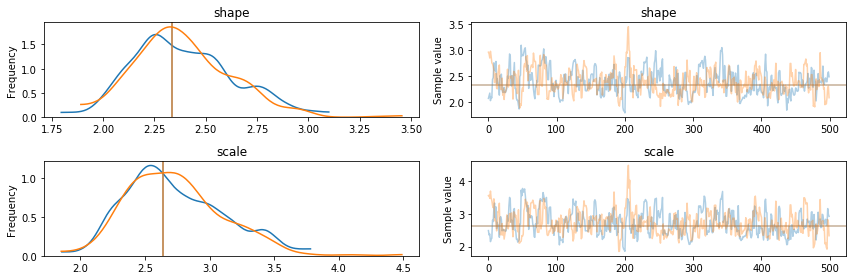

In [5]:
with pm.Model() as m0:
    shape = pm.HalfNormal('shape', 5.)
    scale = pm.HalfNormal('scale', 5.)
    pm.DensityDist('obs', lomax_logp, 
                   observed=dict(value=data,
                                alpha=shape,
                                lam=scale))

    trace0 = pm.sample()
pm.traceplot(trace0, lines=map1);

if $\lambda \mid k, \theta \sim \text{Gamma}(scale=1/k, shape=\theta)$ and $X \mid \lambda \sim \text{Exponential}(\lambda)$ then the marginal distribution of $X\mid k, \theta \sim \text{Lomax}(scale=k, shape=\theta)$.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda, scale, shape]
100%|██████████| 1000/1000 [00:02<00:00, 471.84it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


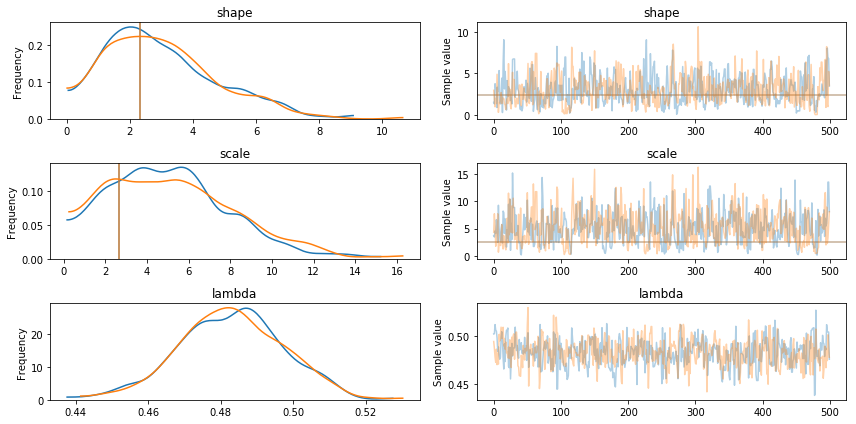

In [6]:
with pm.Model() as m1:
    shape = pm.HalfNormal('shape', 5.)
    scale = pm.HalfNormal('scale', 5.)
    lam = pm.Gamma('lambda', shape, scale)
    pm.Exponential('obs', lam, observed=data)

    trace1 = pm.sample()
pm.traceplot(trace1, lines=map1);

In [7]:
with pm.Model() as m1_:
    shape = 2.5
    scale = 3
    lam = pm.Gamma('lambda', shape, scale)
    pm.Exponential('obs', lam)

    trace1_ = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [obs, lambda]
100%|██████████| 5500/5500 [00:05<00:00, 1095.00it/s]
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


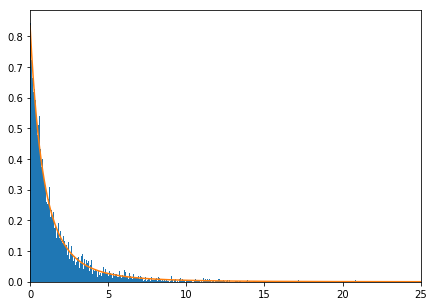

In [8]:
_, ax = plt.subplots(1, 1, figsize=(7, 5))
x = np.linspace(0, 25, 500)
ax.hist(trace1_['obs'], bins=x, normed=True)
ax.plot(x, lomax.pdf(x, c=2.5, scale=3))
ax.set_xlim([0, 25]);